# Description
This code is a sandbox for analysing a company. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
from pprint import pprint
import yfinance as yf

sys.path.append("../")
from edgar_utils import ticker_to_cik, get_companywide_concepts, get_financial_item
from adamodaran_utils import get_industry_df, get_industry_and_sector
from yfinance_utils import get_historical_returns 

pd.set_option('display.width', 1000)

In [3]:
[industry, sector] = get_industry_and_sector("CROX")
industry_df = get_industry_df(industry_list=[industry], country_list=["All"])
pprint(industry_df)

                                                 company industry                  sector  SIC Code        Country  exchange      ticker
61                             Grimoldi S.A. (BASE:GRIM)     Shoe  Consumer Discretionary      3100      Argentina      BASE        GRIM
2095   Bata Shoe Company (Bangladesh) Limited (DSE:BA...     Shoe  Consumer Discretionary      3140     Bangladesh       DSE    BATASHOE
2096                Apex Footwear Limited (DSE:APEXFOOT)     Shoe  Consumer Discretionary      3140     Bangladesh       DSE    APEXFOOT
2097                    Fortune Shoes Ltd. (DSE:FORTUNE)     Shoe  Consumer Discretionary      3140     Bangladesh       DSE     FORTUNE
2098                Legacy Footwear PLC (DSE:LEGACYFOOT)     Shoe  Consumer Discretionary      3140     Bangladesh       DSE  LEGACYFOOT
...                                                  ...      ...                     ...       ...            ...       ...         ...
46412                Steven Madden, Ltd. 

In [4]:
ticker_list = ["NKE", "ADS.DE", "DECK", "ONON", "7936.T", "SKX", "BIRK", "VFC", "PUM.DE", "CROX"]
start_date="2024-01-01"
end_date = "2025-01-01"
prices = yf.download(ticker_list, start=start_date, end=end_date, interval="1mo", progress=False)['Adj Close']
print(prices.head())

Ticker           7936.T      ADS.DE       BIRK        CROX        DECK         NKE       ONON     PUM.DE        SKX        VFC
Date                                                                                                                          
2024-01-01  1124.092041  175.584671  46.389999  101.480003  125.621666   99.817741  26.559999  36.980259  62.439999  16.107992
2024-02-01  1580.529419  186.551239  50.009998  122.250000  149.264999  102.177277  35.020000  41.769993  61.810001  15.990558
2024-03-01  1811.850586  206.370819  47.250000  143.800003  156.876663   92.395073  35.380001  41.327408  61.259998  15.011944
2024-04-01  1677.823364  225.711838  44.770000  124.370003  136.411667   91.028152  31.750000  42.822357  66.050003  12.262124
2024-05-01  2159.328857  230.796341  57.000000  155.639999  182.320007   93.780899  42.540001  46.766262  71.419998  13.069100


In [5]:
# Fetch data for a currency pair
pair = "USDINR=X"  # Replace with the desired currency pair
data = yf.Ticker(pair)
print(data.info)

{'maxAge': 86400, 'priceHint': 4, 'previousClose': 86.145, 'open': 86.145, 'dayLow': 86.07, 'dayHigh': 86.676, 'regularMarketPreviousClose': 86.145, 'regularMarketOpen': 86.145, 'regularMarketDayLow': 86.07, 'regularMarketDayHigh': 86.676, 'bid': 86.666, 'ask': 86.716, 'fiftyTwoWeekLow': 77.5017, 'fiftyTwoWeekHigh': 86.676, 'fiftyDayAverage': 84.83159, 'twoHundredDayAverage': 83.954, 'currency': 'INR', 'exchange': 'CCY', 'quoteType': 'CURRENCY', 'symbol': 'INR=X', 'underlyingSymbol': 'INR=X', 'shortName': 'USD/INR', 'longName': 'USD/INR', 'firstTradeDateEpochUtc': 1070236800, 'timeZoneFullName': 'Europe/London', 'timeZoneShortName': 'GMT', 'uuid': '0993e525-7c86-3d34-933f-3b25938c3717', 'messageBoardId': 'finmb_INR_X', 'trailingPegRatio': None}


In [6]:
mcap = pd.DataFrame(index=prices.index, columns=prices.columns)
for ticker in ticker_list:
    stock = yf.Ticker(ticker)
    shares = int(stock.info.get("sharesOutstanding"))
    currency = stock.info.get("currency")
    xrate = float(yf.Ticker("USD{}=X".format(currency)).info.get('previousClose'))
    mcap.loc[:,ticker] = np.round(prices.loc[:,ticker]*(shares/xrate/1E9),3)

pprint(mcap.head())


Ticker     7936.T  ADS.DE    BIRK   CROX    DECK      NKE    ONON PUM.DE    SKX    VFC
Date                                                                                  
2024-01-01  5.103  32.128   8.713  5.914  19.085  117.909   7.669  5.655  8.217  6.271
2024-02-01  7.175  34.135   9.393  7.125  22.677  120.696  10.112  6.388  8.134  6.225
2024-03-01  8.226  37.761   8.875  8.381  23.833  109.141  10.216   6.32  8.061  5.844
2024-04-01  7.617    41.3   8.409  7.249  20.724  107.526   9.168  6.549  8.692  4.774
2024-05-01  9.803   42.23  10.706  9.071  27.698  110.778  12.284  7.152  9.398  5.088


    begin     end
0     NKE     NKE
1  ADS.DE  ADS.DE
2    DECK    DECK
3    BIRK    ONON
4     SKX  7936.T
5    ONON    BIRK
6     VFC     SKX
7    CROX     VFC
8  PUM.DE  PUM.DE
9  7936.T    CROX


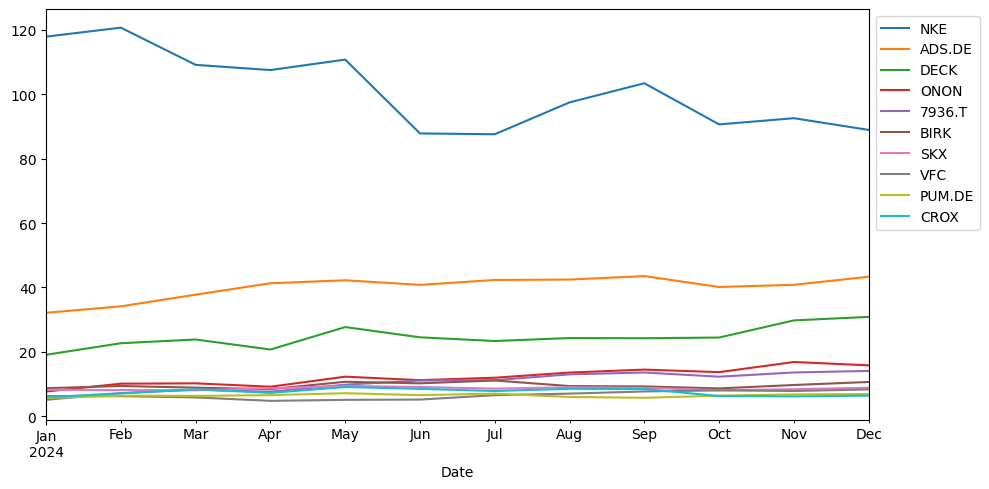

In [7]:
begin_ynames = list(mcap.iloc[0].sort_values(ascending=False).index)
end_ynames = list(mcap.iloc[-1].sort_values(ascending=False).index)

mcapv = mcap[mcap.iloc[-1].sort_values(ascending=False).index]

fig,ax = plt.subplots(1,1,figsize=(10,5))
mcapv.plot(ax=ax)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()

# Display beginning and ending order
mcaporders = pd.DataFrame({'begin':begin_ynames, 'end':end_ynames})
pprint(mcaporders)

Ticker  7936.T  ADS.DE    BIRK   CROX    DECK      NKE    ONON PUM.DE    SKX    VFC
begin    5.103  32.128   8.713  5.914  19.085  117.909   7.669  5.655  8.217  6.271
end     14.074  43.329  10.642  6.384  30.854   88.931  15.815  6.889  8.848   8.32


<Axes: >

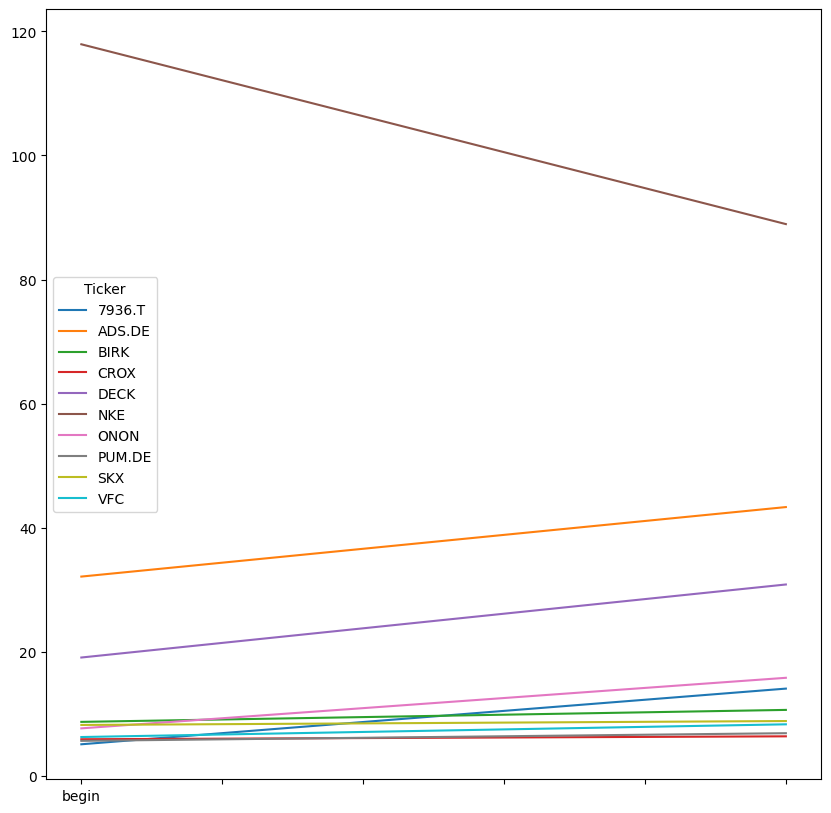

In [8]:
# begin_yvalus = list(mcap.iloc[0].sort_values(ascending=False).index)
# end_yvalues = list(mcap.iloc[-1].sort_values(ascending=False).index)
slopedf = pd.DataFrame({'begin':mcap.iloc[0].sort_index(), 'end':mcap.iloc[-1].sort_index()})
pprint(slopedf.transpose())
fig,ax = plt.subplots(1,1,figsize=(10,10))
slopedf.transpose().plot(ax=ax)

275.79854987262394


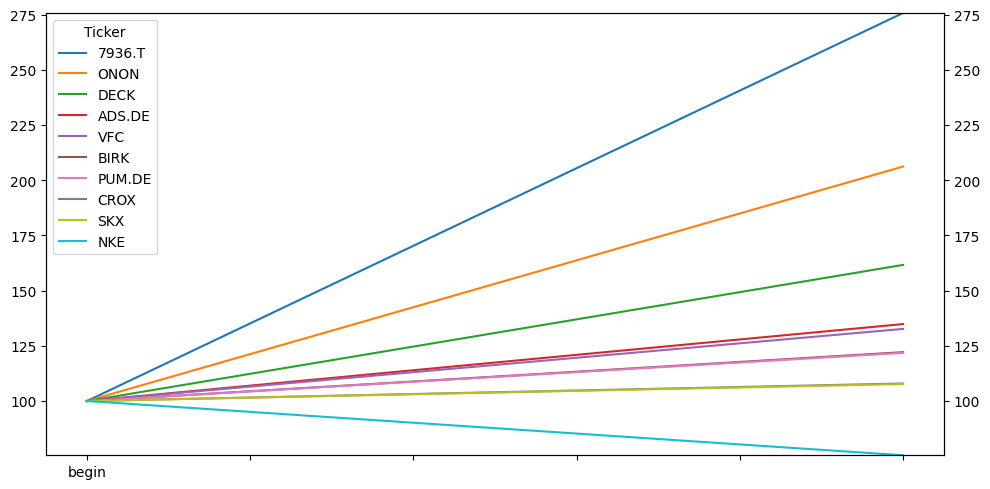

In [14]:
tempdf = slopedf.div(slopedf['begin'], axis=0)*100
percentagedf = tempdf.loc[tempdf['end'].sort_values(ascending=False).index]
# pprint(tempdf)
pprint(percentagedf['end'].max())
fig,ax = plt.subplots(1,1,figsize=(10,5))
percentagedf.transpose().plot(ax=ax)
ax.set_ylim([percentagedf['end'].min(), percentagedf['end'].max()])
# ax.legend(loc="upper left", bbox_to_anchor=(1,1))
ax2 = ax.twinx()
ax2.set_ylim([percentagedf['end'].min(), percentagedf['end'].max()])

plt.tight_layout()